In [92]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
import os
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from google.colab import drive

drive.mount('/content/drive')

# loading dataset
(X, Y), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

(X_2, Y_2), (x_test_2, y_test_2) = tf.keras.datasets.fashion_mnist.load_data()

print("Train dataset shape:", X.shape, Y.shape)
print("Test dataset shape:", x_test.shape, y_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train dataset shape: (60000, 28, 28) (60000,)
Test dataset shape: (10000, 28, 28) (10000,)


In [93]:
# preprocessing data
X = X / 255.0
x_test = x_test / 255.0


X_2 = X_2 / 255.0
x_test_2 = x_test_2 / 255.0

train_size = X.shape[0]
test_size = x_test.shape[0]
img_shape = X.shape[1]

x_train_array = X.reshape(train_size, img_shape, img_shape, 1)
x_test_array = x_test.reshape(test_size, img_shape, img_shape, 1)

x_train_array_2 = X_2.reshape(train_size, img_shape, img_shape, 1)
x_test_array_2 = x_test_2.reshape(test_size, img_shape, img_shape, 1)

In [94]:
# preprocessing lables
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']
num_classes = len(class_names)
Y_ohe = tf.keras.utils.to_categorical(Y, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


Y_ohe_2 = tf.keras.utils.to_categorical(Y_2, 10)
y_test_2 = tf.keras.utils.to_categorical(y_test_2, 10)

In [95]:
validation = 0.2

x_train, x_val, y_train, y_val = train_test_split(x_train_array, Y_ohe, test_size=validation)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_train_array_2, Y_ohe_2, test_size=validation)

def psnr(y_true, y_pred):
          mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
          psnr = 10 * tf.experimental.numpy.log10(1.0 / tf.math.sqrt(mse))
          return psnr

def cmse(y_true, y_pred):
          local_diff = tf.abs(y_true - y_pred)
          num_pixels = tf.size(local_diff)
          num_pixels_to_consider = num_pixels // 2
          local_diff_flat = K.flatten(local_diff)
          threshold_diff, _ = tf.nn.top_k(local_diff_flat, k=num_pixels_to_consider, sorted=True)
          filtered_diff = tf.where(local_diff_flat >= threshold_diff[-1], local_diff_flat, tf.zeros_like(local_diff_flat))
          cmse = 2*K.mean(K.square(filtered_diff)) - tf.keras.metrics.mean_squared_error(y_true, y_pred)
          return cmse


folder_base = "/content/drive/My Drive/SSN Projekt/"
dependencies = {
    'psnr': psnr,
    'cmse': cmse
}

autoenkoder = tf.keras.saving.load_model(os.path.join(folder_base, "MaxPooling2D", "49", "model.h5"), custom_objects=dependencies)

x_train_2 = autoenkoder.predict(x_train_2)
x_val_2 = autoenkoder.predict(x_val_2)
x_test_array_2 = autoenkoder.predict(x_test_array_2)

313/313 [==============================] - 4s 11ms/step


In [98]:
# prepering for data for training
batch_size = 64
num_epochs = 20
patience = 5

# building model
model = tf.keras.Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(28,28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dense(10, activation=tf.nn.softmax))
model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience)

model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

train_model = model.fit( x_train_2, y_train_2,
                  batch_size=batch_size,
                  epochs=num_epochs,
                  validation_data=(x_val_2, y_val_2),
                  callbacks=[early_stop])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               802944    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 804,554
Trainable params: 804,554
Non-trainable params: 0
________________________________________________

In [7]:
score = model.evaluate(x_test_array, y_test, steps=math.ceil(10000/32))
# checking the test loss and test accuracy
print('Model uczony na dekodowanym zbiorze vs zbiór testowy oryginalny')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 1.3209 - accuracy: 0.8099
Model uczony na dekodowanym zbiorze vs zbiór testowy oryginalny
Test loss: 1.320945143699646
Test accuracy: 0.8098999857902527


In [8]:
score = model.evaluate(x_test_array_2, y_test_2, steps=math.ceil(10000/32))
# checking the test loss and test accuracy
print('Model uczony na dekodowanym zbiorze vs zbiór testowy dekodowany')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.4329 - accuracy: 0.8788
Model uczony na dekodowanym zbiorze vs zbiór testowy dekodowany
Test loss: 0.43287914991378784
Test accuracy: 0.8787999749183655


In [102]:
colors = [
    "red",
    "yellow",
    "orange",
    "green",
    "blue",
    "black",
    "darkorange",
    "grey",
    "pink",
    "purple"
]

def draw_roc(y_true, y_pred):
  fig, ax = plt.subplots(figsize=(6, 6))
  label_binarizer = LabelBinarizer().fit(y_true)
  y_onehot_test = label_binarizer.transform(y_true)

  for class_id in range(10):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred[:, class_id],
        name=f"{str(class_names[class_id])} vs the rest",
        color=colors[class_id],
        ax=ax
    )

  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("One-vs-Rest ROC curves")
  plt.legend()
  plt.show()

def draw_confusion_matrix(y_true, y_pred):
  classes = [class_names[i] for i in range(10)]

  y_true_labels = np.argmax(y_true, axis=1)
  y_pred_labels = np.argmax(y_pred, axis=1)

  cm = confusion_matrix(y_true_labels, y_pred_labels)

  df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
  plt.figure(figsize = (10,7))
  cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g', cbar=False)

In [99]:
y_pred_2 = model.predict(x_test_array)

313/313 [==============================] - 1s 2ms/step


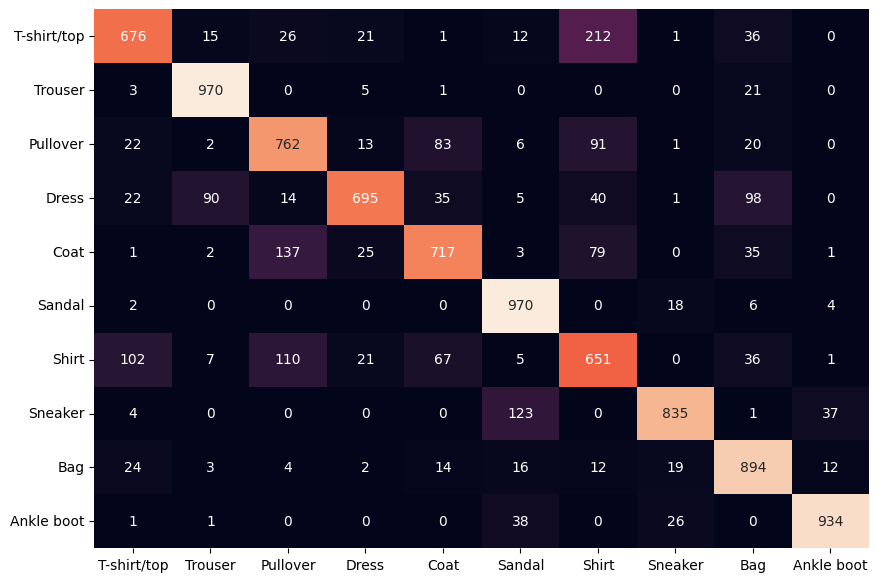

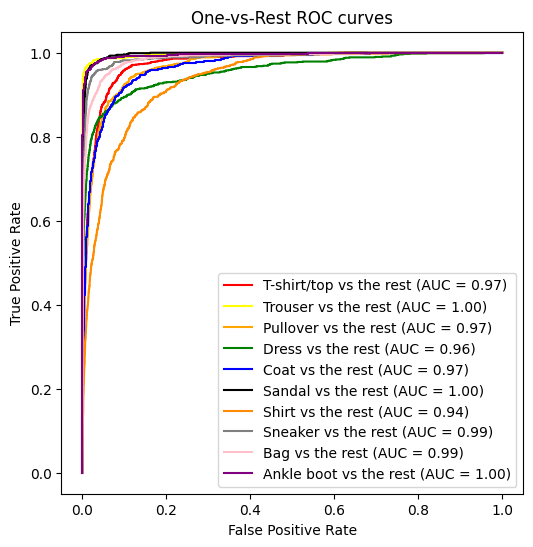

In [101]:
draw_confusion_matrix(y_test, y_pred_2)
draw_roc(y_test, y_pred_2)

In [9]:
# prepering for data for training
validation = 0.2
batch_size = 64
num_epochs = 20
patience = 5

# building model
model = tf.keras.Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(28,28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dense(10, activation=tf.nn.softmax))
model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience)

model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

train_model = model.fit( x_train, y_train,
                  batch_size=batch_size,
                  epochs=num_epochs,
                  validation_data=(x_val, y_val),
                  callbacks=[early_stop])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               802944    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 804,554
Trainable params: 804,554
Non-trainable params: 0
________________________________________________

In [10]:
score = model.evaluate(x_test_array, y_test, steps=math.ceil(10000/32))
# checking the test loss and test accuracy
print('Model uczony na oryginalnym zbiorze vs zbiór testowy oryginalny')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.5197 - accuracy: 0.9108
Model uczony na oryginalnym zbiorze vs zbiór testowy oryginalny
Test loss: 0.5197128057479858
Test accuracy: 0.9107999801635742


In [11]:
score = model.evaluate(x_test_array_2, y_test_2, steps=math.ceil(10000/32))
# checking the test loss and test accuracy
print('Model uczony na oryginalnym zbiorze vs zbiór testowy dekodowany')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.8439 - accuracy: 0.8389
Model uczony na oryginalnym zbiorze vs zbiór testowy dekodowany
Test loss: 0.8438774347305298
Test accuracy: 0.8389000296592712


In [90]:
y_pred = model.predict(x_test_array_2)

313/313 [==============================] - 1s 2ms/step


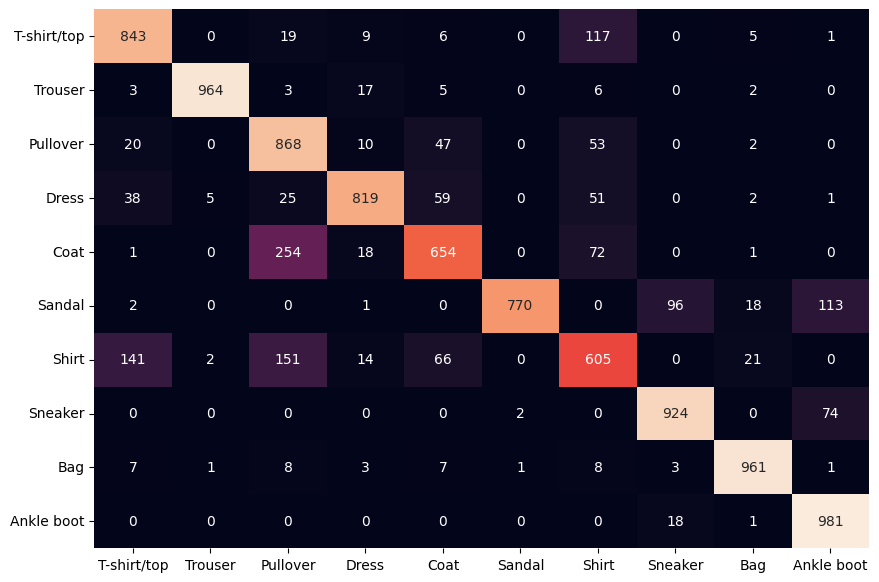

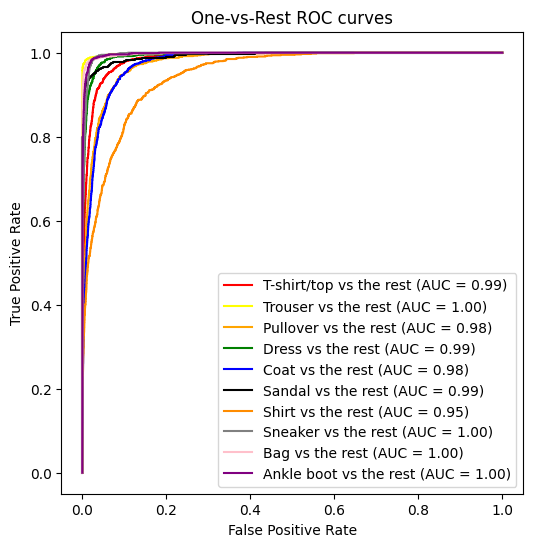

In [97]:
draw_confusion_matrix(y_test, y_pred)
draw_roc(y_test, y_pred)